## Setting Up the environment

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Accessing Clean Dataset

In [24]:
original_df1 = pd.read_csv('./dataset1_cleaned.csv', parse_dates=True)
original_df2 = pd.read_csv('./dataset2_cleaned.csv', parse_dates=True)

# copying dataframe into new variable from original variable
df1 = original_df1
df2 = original_df2

df1.head()

,start_time,bat_landing_to_food_min,habit,rat_period_start,rat_period_end,min_after_rat_arrival,risk,reward,month,sunset_time,min_after_sunset,season,date,chronology_check
0,2017-12-26 20:57:00,0.016667,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.983333,0,0,0,2017-12-26 16:43:00,254.916667,0,2017-12-26,True
1,2017-12-26 20:57:00,0.083333,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.316667,0,0,0,2017-12-26 16:43:00,254.250000,0,2017-12-26,True
2,2017-12-26 21:24:00,0.050000,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,2.016667,0,1,0,2017-12-26 16:43:00,281.616667,0,2017-12-26,True
3,2017-12-26 21:24:00,0.250000,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,1.466667,1,0,0,2017-12-26 16:43:00,281.066667,0,2017-12-26,True
4,2017-12-26 21:24:00,0.100000,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,1.883333,0,1,0,2017-12-26 16:43:00,281.483333,0,2017-12-26,True


In [25]:
df2.head()

,time,month,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,minutes_after_sunset,date
0,2017-12-26 16:13:00,0,20,4.000000,0.0,0,-30.0,2017-12-26
1,2017-12-26 16:43:00,0,28,4.000000,0.0,0,0.0,2017-12-26
2,2017-12-26 17:13:00,0,25,4.000000,0.0,0,30.0,2017-12-26
3,2017-12-26 17:43:00,0,71,4.000000,0.0,0,60.0,2017-12-26
4,2017-12-26 18:13:00,0,44,3.753857,0.0,0,90.0,2017-12-26


## Combining the two dataset

In [26]:
df1['start_time'] = pd.to_datetime(df1['start_time']).sort_values(ascending=True)
df2['time'] = pd.to_datetime(df2['time']).sort_values(ascending=True)

# converting individual bat landing time to 30 min interval time. 
df1['start_time_interval'] = df1['start_time'].dt.floor('30min').sort_values(ascending=True)
df2['time_interval'] = df2['time'].dt.floor('30min').sort_values(ascending=True)

#Merging df1 and df2
data = pd.merge(df1, df2, left_on=['date', 'start_time_interval'], right_on=['date', 'time_interval'], how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_time               906 non-null    datetime64[ns]
 1   bat_landing_to_food_min  906 non-null    float64       
 2   habit                    906 non-null    object        
 3   rat_period_start         906 non-null    object        
 4   rat_period_end           906 non-null    object        
 5   min_after_rat_arrival    906 non-null    float64       
 6   risk                     906 non-null    int64         
 7   reward                   906 non-null    int64         
 8   month_x                  906 non-null    int64         
 9   sunset_time              906 non-null    object        
 10  min_after_sunset         906 non-null    float64       
 11  season                   906 non-null    int64         
 12  date                     906 non-nul

## Feature Engineering

### Confirming the rat presence during bat landing
In this section, we are confirming if there was rat on food platform when bat landed.

In [27]:
data['rat_present'] = data['rat_arrival_number'].fillna(0) > 0
data['rat_present'] = data['rat_present'].astype(int)
data['rat_present'].value_counts()

rat_present
1    592
0    314
Name: count, dtype: int64

In [28]:
data.head()

,start_time,bat_landing_to_food_min,habit,rat_period_start,rat_period_end,min_after_rat_arrival,risk,reward,month_x,sunset_time,...,start_time_interval,time,month_y,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,minutes_after_sunset,time_interval,rat_present
0,2017-12-26 20:57:00,0.016667,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.983333,0,0,0,2017-12-26 16:43:00,...,2017-12-26 20:30:00,2017-12-26 20:43:00,0,51,2.968874,0.0,2,240.0,2017-12-26 20:30:00,1
1,2017-12-26 20:57:00,0.083333,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.316667,0,0,0,2017-12-26 16:43:00,...,2017-12-26 20:30:00,2017-12-26 20:43:00,0,51,2.968874,0.0,2,240.0,2017-12-26 20:30:00,1
2,2017-12-26 21:24:00,0.050000,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,2.016667,0,1,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1
3,2017-12-26 21:24:00,0.250000,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,1.466667,1,0,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1
4,2017-12-26 21:24:00,0.100000,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,1.883333,0,1,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1


### Food Availability Unit
We have given food availability data but the unit is unkown. So we are truning given data into fraction of 4, so it's easy to interpret. Zero (0) represent no food and 1 represent food. 

In [29]:
data['food_fraction'] = (data['food_availability'] / 4).round(2) 
data['food_fraction'].unique()

array([0.74, 0.64, 0.24, 0.18, 0.77, 0.99, 0.48, 0.59, 0.47, 0.25, 0.9 ,
       0.29, 0.8 , 0.5 , 0.26, 1.  , 0.98, 0.37, 0.51, 0.75, 0.72, 0.22,
       0.46, 0.96, 0.44, 0.61, 0.7 , 0.19, 0.69, 0.57, 0.97, 0.89, 0.52,
       0.38, 0.53, 0.78, 0.49, 0.28, 0.62, 0.73, 0.65, 0.56, 0.86, 0.36,
       0.87, 0.76, 0.71, 0.6 , 0.58, 0.45, 0.93, 0.2 ])

### Creating a Seasons Feature
The Egyptian weather pattern is completely different from Australia. As winter generally falls in December to Februaru, while Spring falls from March to May in Egypt. Beside this, it also help us with our investigation, where we can see the behaviours based on seasonal changes.

In [30]:
# Extracting the month from the 'date' column in merged dataset.
data['month_num'] = pd.to_datetime(data['date']).dt.month

# Defining a function to categorize months into Egyptian Seasons
def egyptian_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Other'
    
# Creating new 'season_egypt' column
data['season_egypt'] = data['month_num'].apply(egyptian_season)

In [31]:
data['season_egypt'].unique()

array(['Winter', 'Spring'], dtype=object)

### Counting the number of bat landing 

In [32]:
bat_count = (data.groupby(["date","start_time_interval"]).size()
             .rename("bat_count").reset_index())
data = data.merge(bat_count, on=["date","start_time_interval"], how="left")

### Comparing number of rat vs bat

In [33]:
data['rats_more_than_bats'] = (data['rat_arrival_number'] > data['bat_count']).astype(int)
data['rats_more_than_bats'].unique()

array([0, 1])

### Interactive Terms

In [34]:
# calculating bat risk taking behavior in presence of rat
data['risk_rat_present'] = (data['rats_more_than_bats'] * data['risk']) 

# calculating bat risk taking behavior difference in food availability
data['risk_food_availability'] = (data['food_fraction'] * data['risk']) 

In [35]:
# Calculating bat risk taking behaviour underdifferent category with reward
data['risk_reward'] = data['risk_rat_present'] * data['risk_food_availability'] * data['reward']

## Data Cleaning
The merged dataframe might contains duplicate and redundant columns after the join. This step will clean up the merged dataframe by dropping unnecessary columns and renaming columns for clarity

In [36]:
# Dropping redundant columns after merging
data = data.drop(columns=['time', 'time_interval', 'start_time_interval', 'food_availability', 'season', 'month_y', 'month_x', 'minutes_after_sunset', 'habit'])

# Renaming Columns for clarity 
data = data.rename(columns={'month_num': 'month'})

data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_time               906 non-null    datetime64[ns]
 1   bat_landing_to_food_min  906 non-null    float64       
 2   rat_period_start         906 non-null    object        
 3   rat_period_end           906 non-null    object        
 4   min_after_rat_arrival    906 non-null    float64       
 5   risk                     906 non-null    int64         
 6   reward                   906 non-null    int64         
 7   sunset_time              906 non-null    object        
 8   min_after_sunset         906 non-null    float64       
 9   date                     906 non-null    object        
 10  chronology_check         906 non-null    bool          
 11  bat_landing_number       906 non-null    int64         
 12  rat_minutes              906 non-nul

<Axes: ylabel='bat_landing_to_food_min'>

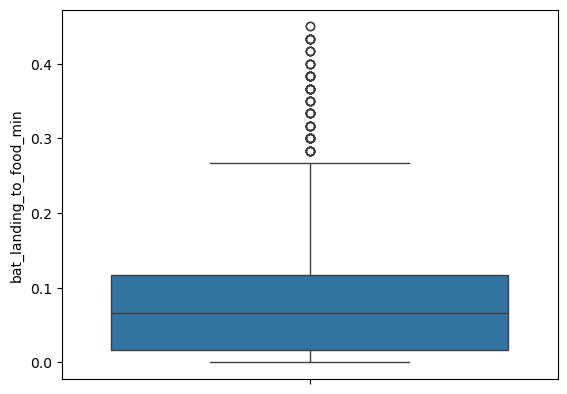

In [37]:
sns.boxplot(y = data['bat_landing_to_food_min'])

# Treating Outlier

In [38]:
def detect_outlier(col):
   num = pd.to_numeric(col, errors='coerce') # Making sure all the values are numeric.
   q1 = num.quantile(0.25) # calculating first quantile
   q3 = num.quantile(0.75) # calcualting third quantile
   IQR = q3 - q1 # calculating Interquartile range
   lo = q1 - (1.5 * IQR) # calculating lower fence for data, a potential outlier.
   hi = q3 + (1.5 * IQR) # calculating high fence for data, a potential outlier
   outlier = (num < lo) | (num > hi)
   return outlier  # returns boolen value


# treating outlier in specific columns 
col_name = ['bat_landing_to_food_min','min_after_rat_arrival', 'rat_arrival_number'] 
for col in col_name:
    outlier = detect_outlier(data[col])  # detecting the outliers row in a given col
    median_value = data[col].median() # calculating median of given value
    data.loc[outlier, col] = median_value # flagging specific row for given column

<Axes: ylabel='bat_landing_to_food_min'>

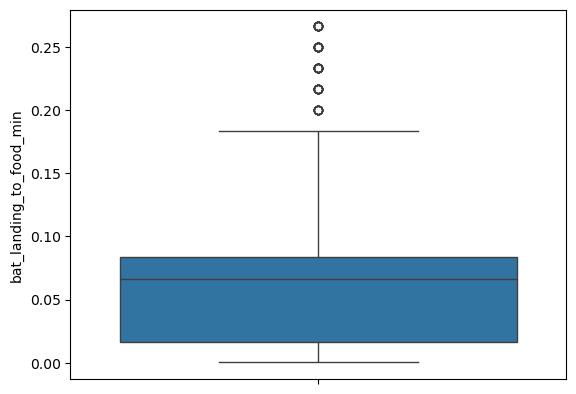

In [39]:
sns.boxplot(y = data['bat_landing_to_food_min'])

## Preparing data for regression
We are encoding the data, as linear regression requires numerical inputs. So any categorical features must be converted into numbers in a way that preserves meaning.

* __Dependent Variable (Y):__ `bat_landing_to_food_min`
* __Predictors (X):__ `rat_present`, `food_fraction`, `bat_count`, `rat_minutes`, `minutes_after_sunsets`


### One-hot encoding for categorical values

In [40]:
#copying original data for encoding 
enc_data = data

# selecting categorical columns
categorical_cols = ['season_egypt']

#creating one-hot encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = pd.DataFrame(
    encoder.fit_transform(enc_data[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)

# Merging encoded columns back into main Dataframe
enc_data = pd.concat([enc_data.drop(columns=categorical_cols).reset_index(drop=True),
                          encoded_data.reset_index(drop=True)], axis = 1)

#Interactive terms
enc_data['seasonal_rat_present'] = enc_data['season_egypt_Winter'] * enc_data['rat_present']
enc_data['seasonal_food_availability'] = enc_data['season_egypt_Winter'] * enc_data['food_fraction']

### Grouping data based on season
We are grouping dataframe by season. Then we will use 80% - 20% data train and test our linear regression.  

In [41]:
winter_df = enc_data[enc_data['season_egypt_Winter'] == 1.0]
spring_df = enc_data[enc_data['season_egypt_Winter'] == 0.0]


## Features to be use

In [42]:
target_col = 'bat_landing_to_food_min'

cols_to_exclude = {
     target_col, 'start_time', 'rat_period_start', 'rat_period_end', 'sunset_time',
    'date', 'chronology_check', 'month', 'month_num', 'minutes_after_sunset', }
features = [
    col for col in enc_data.columns
    if col not in cols_to_exclude
    ]
# features = [
#  'risk_reward', 'season_egypt_Winter', 'min_after_sunset',    
# ]

# X_winter = winter_df[features]
# Y_winter = winter_df['bat_landing_to_food_min']

# X_spring = spring_df[features]
# Y_spring = spring_df['bat_landing_to_food_min']

In [43]:
X = enc_data[features].copy()
X.corr()

## pair of independent ariables with correlation greater than 0.5 
k=X.corr()
z=[[str(i),str(j)] for i in k.columns for j in k.columns if(k.loc[i,j]>abs(0.5))&(i!=j)]
z,len(z)

#importing varience inflation factor from the stats model
vif_data=X
## calculating VIF for every column
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF


min_after_rat_arrival          2.712601
risk                          24.834842
reward                         3.520749
min_after_sunset               6.044259
bat_landing_number             6.106911
rat_minutes                    1.056786
rat_arrival_number            10.466661
rat_present                   13.036890
food_fraction                 11.127209
bat_count                      4.531445
rats_more_than_bats            2.187208
risk_rat_present               2.331444
risk_food_availability        25.243069
risk_reward                    1.377818
season_egypt_Winter           13.061587
seasonal_rat_present           4.715729
seasonal_food_availability     9.487039
dtype: float64

In [44]:

def MC_remover(data):
    vif=pd.Series([variance_inflation_factor(data.values,i)for i in range(data.shape[1])],index=data.columns)
    if vif.max()>5:
        print(vif[vif == vif.max()].index[0],'has been removed')
        data = data.drop(columns=[vif[vif==vif.max()].index[0]])
        return data
    else:
        print("No multicollinearity present anymore")
        return data

In [45]:
for i in range(10):
    vif_data=MC_remover(vif_data)
vif_data.head()

risk_food_availability has been removed
rat_present has been removed
season_egypt_Winter has been removed
food_fraction has been removed
bat_landing_number has been removed
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore


,min_after_rat_arrival,risk,reward,min_after_sunset,rat_minutes,rat_arrival_number,bat_count,rats_more_than_bats,risk_rat_present,risk_reward,seasonal_rat_present,seasonal_food_availability
0,3.983333,0,0,254.916667,0.0,2,2,0,0,0.0,1.0,0.74
1,3.316667,0,0,254.250000,0.0,2,2,0,0,0.0,1.0,0.74
2,2.016667,0,1,281.616667,0.0,1,7,0,0,0.0,1.0,0.64
3,1.466667,1,0,281.066667,0.0,1,7,0,0,0.0,1.0,0.64
4,1.883333,0,1,281.483333,0.0,1,7,0,0,0.0,1.0,0.64


In [46]:
## calculating VIF for remaining columns
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF,len(vif_data.columns)

(min_after_rat_arrival         2.537626
 risk                          2.397978
 reward                        2.654683
 min_after_sunset              4.476932
 rat_minutes                   1.052920
 rat_arrival_number            2.551056
 bat_count                     3.184185
 rats_more_than_bats           2.098519
 risk_rat_present              2.322331
 risk_reward                   1.372506
 seasonal_rat_present          2.915968
 seasonal_food_availability    2.746748
 dtype: float64,
 12)

In [47]:
w_features = ['min_after_rat_arrival', 'risk', 'reward', 'rat_arrival_number',  
                'rats_more_than_bats', 'season_egypt_Winter']
s_features = ['min_after_rat_arrival', 'risk', 'reward', 'min_after_sunset', 'rat_minutes',  
                'season_egypt_Winter']
# new_features = ['min_after_rat_arrival', 'risk', 'reward', 'min_after_sunset', 'rat_minutes', 'rat_arrival_number',  
                # 'rats_more_than_bats', 'seasonal_rat_present', 'seasonal_food_availability']

### Correlation Visualization

### Winter Dataset

<Figure size 1200x1000 with 0 Axes>

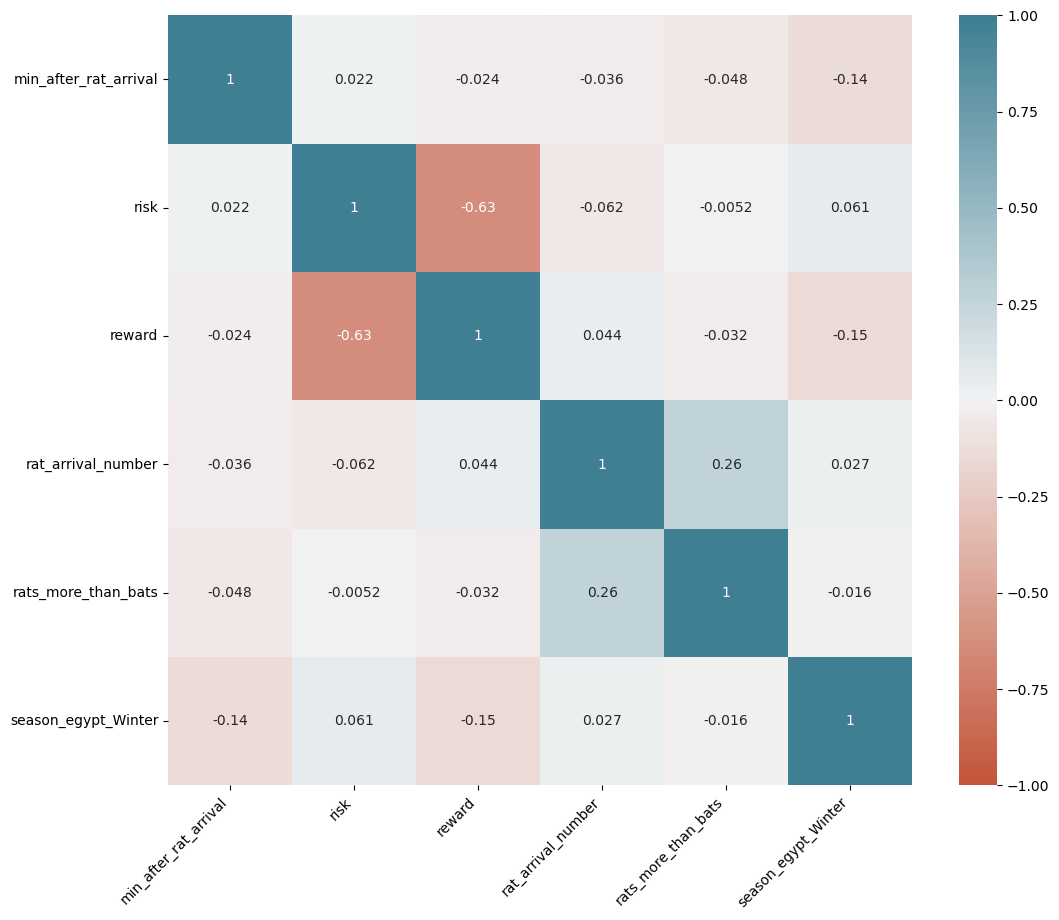

In [48]:
corr = X.corr()
plt.figure(figsize=(12, 10))  # Adjust width and height as needed

chosen_vars = w_features
corr_subset = corr.loc[chosen_vars, chosen_vars]

plt.figure(figsize=(12, 10))


ax = sns.heatmap(
    corr_subset, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True
)
# customise the labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

### Spring Dataset

<Figure size 1200x1000 with 0 Axes>

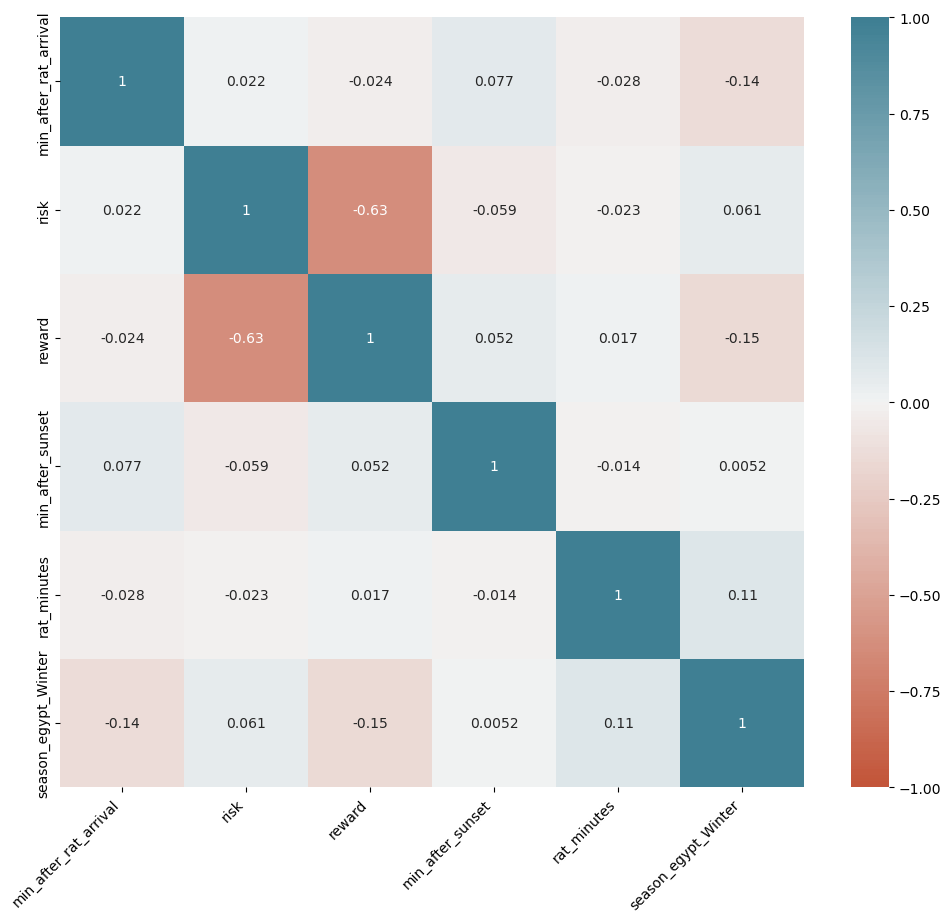

In [69]:
corr = X.corr()
plt.figure(figsize=(12, 10))  # Adjust width and height as needed

chosen_vars = s_features
corr_subset = corr.loc[chosen_vars, chosen_vars]

plt.figure(figsize=(12, 10))


ax = sns.heatmap(
    corr_subset, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True
)
# customise the labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

## Regression Logic

### Train/Test split within each season

In [49]:
def split_xy(df, feature_cols, target_col, test_size=0.2, random_state = 42):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

Xw_train, Xw_test, yw_train, yw_test = split_xy(winter_df, w_features, target_col)
Xs_train, Xs_test, ys_train, ys_test = split_xy(spring_df, s_features, target_col)

### Standardising the Data
After standardising the data, every varibale will be on same scale, avoiding issues with large-value feature dominate smaller ones like min_after_sunset and food_fraction

In [50]:
# Winter scaler (fit on winter train only)
winter_scaler = StandardScaler()
Xw_train_scaled = winter_scaler.fit_transform(Xw_train)
Xw_test_scaled  = winter_scaler.transform(Xw_test)

# Spring scaler (fit on spring train only)
spring_scaler = StandardScaler()
Xs_train_scaled = spring_scaler.fit_transform(Xs_train)
Xs_test_scaled  = spring_scaler.transform(Xs_test)

## Linear Regression

In [51]:
LRwinter = LinearRegression().fit(Xw_train_scaled, yw_train)
LRspring = LinearRegression().fit(Xs_train_scaled, ys_train)

## Regression Coefficients

In [52]:
coef_winter = pd.Series(LRwinter.coef_, index=w_features).sort_values(key=abs, ascending=False)
coef_spring = pd.Series(LRspring.coef_, index=s_features).sort_values(key=abs, ascending=False)

### Feature Importance Visualization

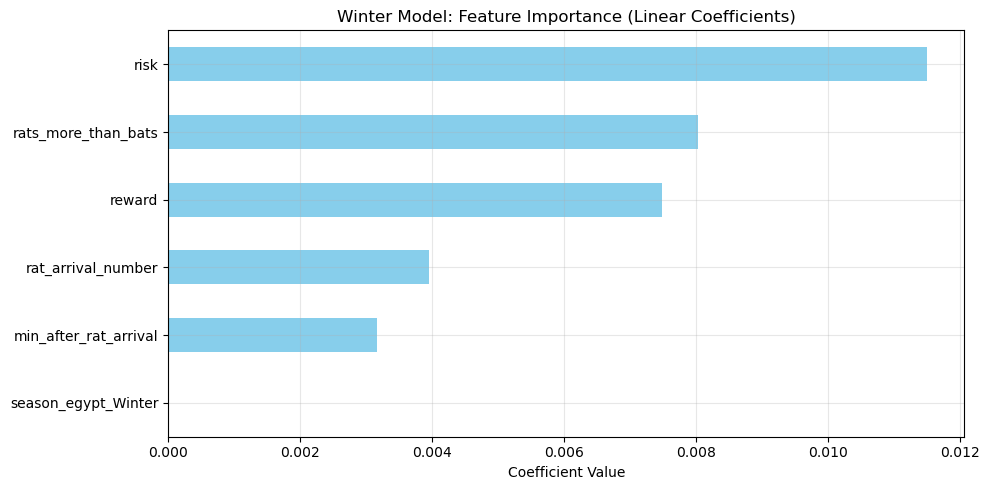

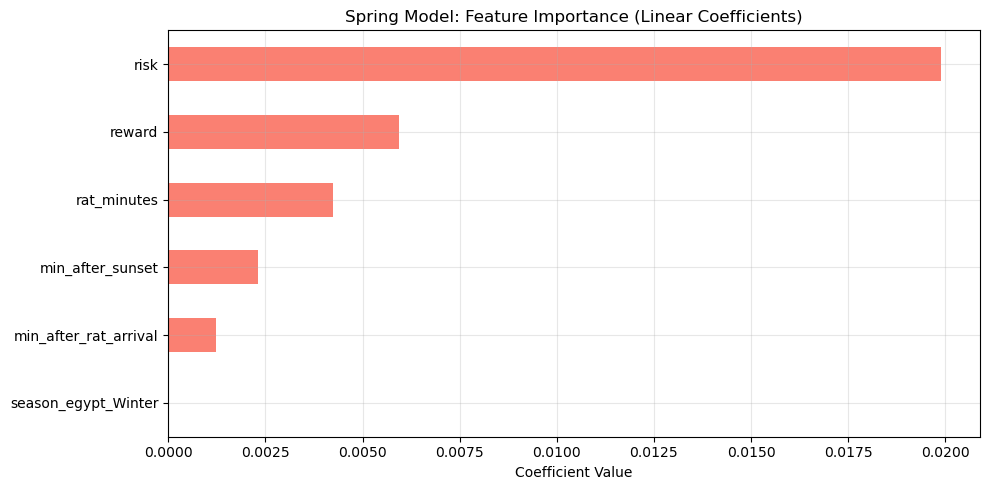

In [53]:
# --- Feature Importance (Absolute Coefficients) ---


# Plot Winter Coefficients
plt.figure(figsize=(10, 5))
coef_winter.sort_values(key=abs, ascending=True).plot(kind='barh', color='skyblue')
plt.title("Winter Model: Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Spring Coefficients
plt.figure(figsize=(10, 5))
coef_spring.sort_values(key=abs, ascending=True).plot(kind='barh', color='salmon')
plt.title("Spring Model: Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [54]:
coef_winter.head(10)

risk                     0.011494
rats_more_than_bats      0.008037
reward                   0.007491
rat_arrival_number       0.003951
min_after_rat_arrival    0.003161
season_egypt_Winter      0.000000
dtype: float64

In [55]:
coef_spring.head(10)

risk                     0.019895
reward                   0.005941
rat_minutes              0.004237
min_after_sunset         0.002316
min_after_rat_arrival    0.001231
season_egypt_Winter      0.000000
dtype: float64

## MSE, RMSE and R square - Training Dataset

In [56]:
# Predict values for each model
y_pred_winter = LRwinter.predict(Xw_train_scaled)
y_pred_spring = LRspring.predict(Xs_train_scaled)

print(f'y_pred_winter: {y_pred_winter}')
print(f'y_pred_spring: {y_pred_spring}')

y_pred_winter: [0.06028717 0.05612097 0.05716713 0.05951221 0.06139048 0.04441965
 0.05772239 0.04372445 0.05332059 0.05261408 0.06176299 0.05976907
 0.11881996 0.06739935 0.05322639 0.06032852 0.05585407 0.05407995
 0.06086808 0.04321074 0.05607387 0.06795451 0.04535495 0.04612658
 0.0629719  0.03374353 0.03784693 0.063196   0.06750925 0.0309803
 0.05795789 0.05305369 0.06226539 0.06319171 0.0625951  0.05256698
 0.05712003 0.05301234 0.11716004 0.06047987 0.06903782 0.05575987
 0.06563089 0.06053838 0.05182907 0.06561519 0.05956496 0.06883372
 0.06009877 0.06162598 0.05355609 0.06049128 0.04847928 0.06760345
 0.0544667  0.05334204 0.05447245 0.06113498 0.05576982 0.0626108
 0.06637884 0.02992839 0.05640358 0.05698448 0.05787929 0.05201748
 0.06033427 0.05261408 0.0624852  0.05176627 0.05431545 0.05973201
 0.06060118 0.08354812 0.03993506 0.11402    0.04609285 0.0539486
 0.05534591 0.05175057 0.05344619 0.0304308  0.0628506  0.06767191
 0.06019727 0.06042847 0.06837276 0.05247278 0.052

In [57]:
# Winter Metrics
mse_winter = mean_squared_error(yw_train, y_pred_winter)
rmse_winter = np.sqrt(mse_winter)
r2_winter = r2_score(yw_train, y_pred_winter)

print(f'mse: {mse_winter}, rmse: {rmse_winter} & r2: {r2_winter}')

mse: 0.0035395419878205955, rmse: 0.05949405002032216 & r2: 0.04322039134465738


In [58]:
# Spring Metrics
mse_spring = mean_squared_error(ys_train, y_pred_spring)
rmse_spring = np.sqrt(mse_spring)
r2_spring = r2_score(ys_train, y_pred_spring)

print(f'mse: {mse_spring}, rmse: {rmse_spring} & r2: {r2_spring}')

mse: 0.0036518317271736892, rmse: 0.060430387448482316 & r2: 0.07696661291787255


## MSE, RMSE and R square - Test Dataset

In [59]:
# Predict values for each model on the test set
y_pred_winter_test = LRwinter.predict(Xw_test_scaled)
y_pred_spring_test = LRspring.predict(Xs_test_scaled)

print(f'y_pred_winter: {y_pred_winter_test}')
print(f'y_pred_spring: {y_pred_spring_test}')

y_pred_winter: [0.05417415 0.06874957 0.06764051 0.05787929 0.05987897 0.05998887
 0.05473936 0.05412705 0.07215651 0.06781321 0.06079387 0.04944936
 0.05517321 0.05980047 0.05461376 0.05331064 0.06129198 0.04770997
 0.04877758 0.05572847 0.05173487 0.06793881 0.05335199 0.04840078
 0.06029722 0.05372879 0.05976907 0.03149841 0.03767423 0.05176627
 0.06096228]
y_pred_spring: [0.05364774 0.05480392 0.05395476 0.08272076 0.08658005 0.08363148
 0.09178042 0.08308526 0.08948867 0.1005094  0.05663272 0.10048777
 0.0591726  0.05599634 0.05447109 0.0521707  0.05673237 0.04033165
 0.05475551 0.0574607  0.09464519 0.08629937 0.0591848  0.05498012
 0.05501953 0.09526572 0.05974807 0.05116072 0.08407512 0.08446644
 0.05047519 0.08551184 0.09412542 0.08346706 0.08495821 0.09129949
 0.0560132  0.08010708 0.04725898 0.03992236 0.08574868 0.05422399
 0.07908807 0.0787411  0.05276777 0.08621168 0.05259778 0.09433755
 0.08275585 0.08784836 0.0559235  0.08111482 0.05539856 0.06212152
 0.05942153 0.05023

In [60]:
# Winter Test Metrics
mse_winter_test = mean_squared_error(yw_test, y_pred_winter_test)
rmse_winter_test = np.sqrt(mse_winter_test)
r2_winter_test = r2_score(yw_test, y_pred_winter_test)

print(f'mse: {mse_winter_test}, rmse: {rmse_winter_test} & r2: {r2_winter_test}')

mse: 0.0029112030786029256, rmse: 0.0539555657796573 & r2: -0.02516468837780428


In [61]:
# Spring Test Metrics
mse_spring_test = mean_squared_error(ys_test, y_pred_spring_test)
rmse_spring_test = np.sqrt(mse_spring_test)
r2_spring_test = r2_score(ys_test, y_pred_spring_test)

print(f'mse: {mse_spring_test}, rmse: {rmse_spring_test} & r2: {r2_spring_test}')

mse: 0.0032526469937181677, rmse: 0.05703198220050017 & r2: 0.030171394264522644


## Cross Validation

In [62]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

winter_mse_scores = []
winter_rmse_scores = []
winter_r2_scores = []

X_winter = winter_df[w_features]
y_winter = winter_df[target_col]

for train_index, val_index in kf.split(X_winter):
    X_train, X_val = X_winter.iloc[train_index], X_winter.iloc[val_index]
    y_train, y_val = y_winter.iloc[train_index], y_winter.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    winter_mse_scores.append(mse)
    winter_rmse_scores.append(rmse)
    winter_r2_scores.append(r2)

spring_mse_scores = []
spring_rmse_scores = []
spring_r2_scores = []

# Assuming spring_df and new_features are already defined
X_spring = spring_df[s_features]
y_spring = spring_df[target_col]

for train_index, val_index in kf.split(X_spring):
    X_train, X_val = X_spring.iloc[train_index], X_spring.iloc[val_index]
    y_train, y_val = y_spring.iloc[train_index], y_spring.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    spring_mse_scores.append(mse)
    spring_rmse_scores.append(rmse)
    spring_r2_scores.append(r2)

print("Winter Model Cross-Validation Metrics:")
print(f"Average MSE: {np.mean(winter_mse_scores):.4f}")
print(f"Average RMSE: {np.mean(winter_rmse_scores):.4f}")
print(f"Average R-squared: {np.mean(winter_r2_scores):.4f}")

print("\nSpring Model Cross-Validation Metrics:")
print(f"Average MSE: {np.mean(spring_mse_scores):.4f}")
print(f"Average RMSE: {np.mean(spring_rmse_scores):.4f}")
print(f"Average R-squared: {np.mean(spring_r2_scores):.4f}")

Winter Model Cross-Validation Metrics:
Average MSE: 0.0038
Average RMSE: 0.0606
Average R-squared: -0.2137

Spring Model Cross-Validation Metrics:
Average MSE: 0.0036
Average RMSE: 0.0600
Average R-squared: 0.0421


## Residual Analysis

In [63]:
# Residuals
residuals_winter = yw_train - LRwinter.predict(Xw_train_scaled)
residuals_spring = ys_train - LRspring.predict(Xs_train_scaled)

print(f'residuals_winter: {residuals_winter}')
print(f'residuals_spring: {residuals_spring}')

residuals_winter: 15     0.006379
125   -0.039454
11    -0.023834
127   -0.026179
51    -0.028057
         ...   
71    -0.045159
106   -0.000299
14    -0.026514
92     0.056489
102   -0.033365
Name: bat_landing_to_food_min, Length: 120, dtype: float64
residuals_spring: 220   -0.019444
416    0.013479
282   -0.056549
195   -0.032258
221    0.069275
         ...   
222    0.013642
257   -0.042005
421   -0.019973
586    0.011423
253   -0.037644
Name: bat_landing_to_food_min, Length: 604, dtype: float64


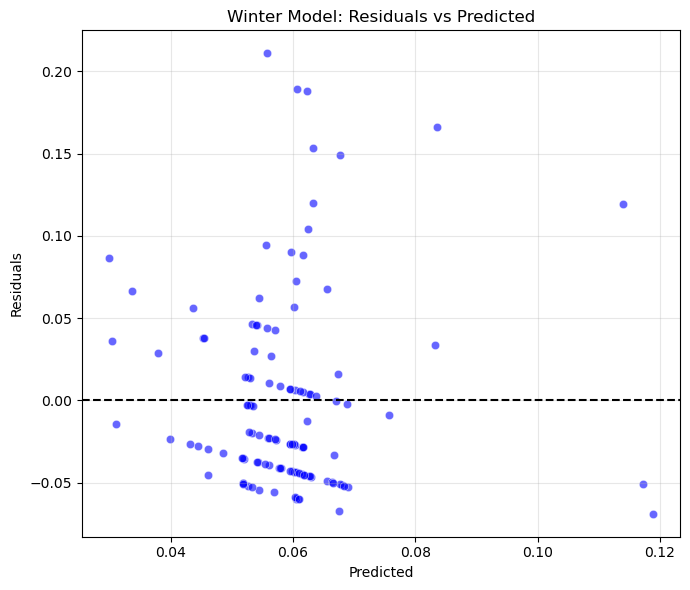

In [64]:
# Residual Plot - Winter
plt.figure(figsize=(7, 6))
sns.scatterplot(x=LRwinter.predict(Xw_train_scaled), y=residuals_winter, color='blue', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Winter Model: Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

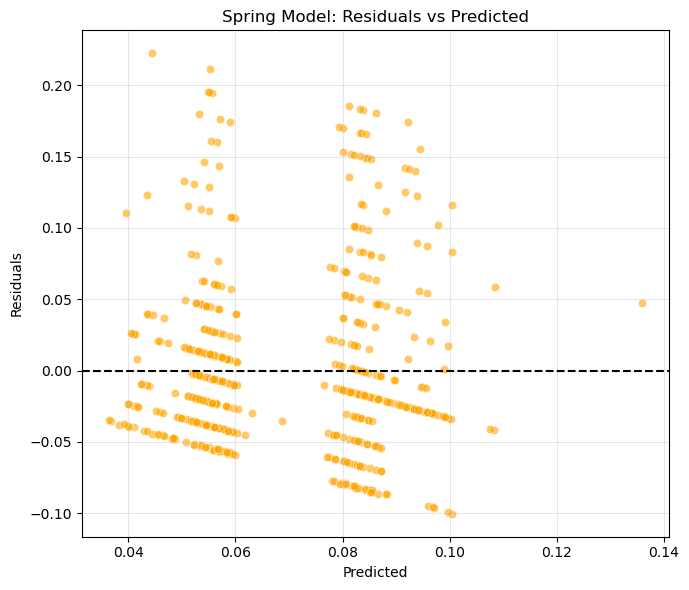

In [65]:
# Residual Plot - Spring
plt.figure(figsize=(7, 6))
sns.scatterplot(x=LRspring.predict(Xs_train_scaled), y=residuals_spring, color='orange', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Spring Model: Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Histogram of Residual

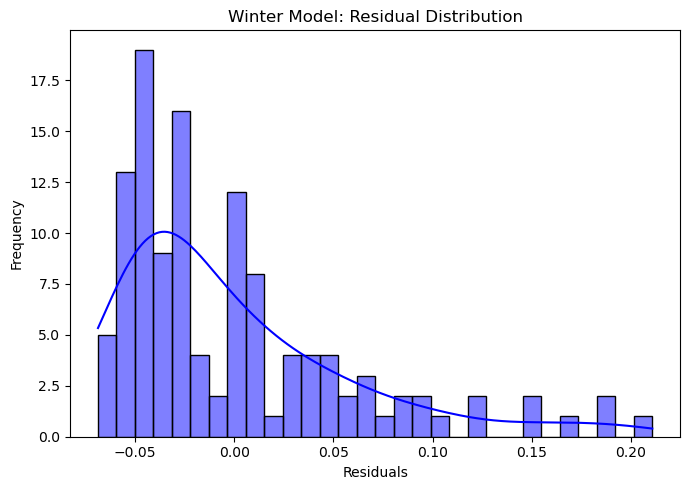

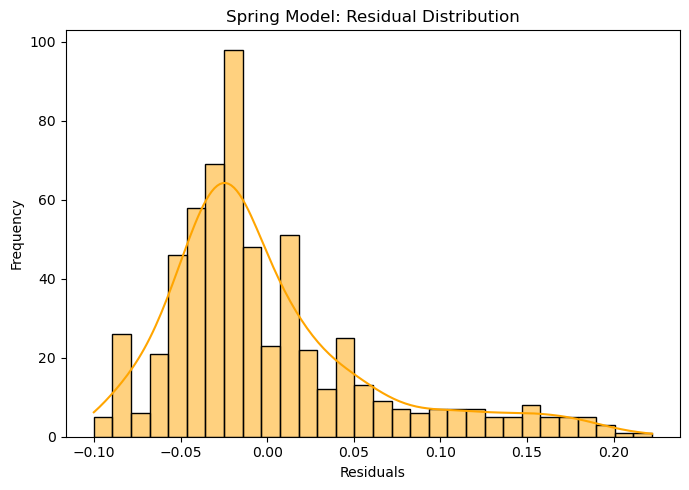

In [66]:
# Histogram of Residuals - Winter
plt.figure(figsize=(7, 5))
sns.histplot(residuals_winter, kde=True, color='blue', bins=30)
plt.title("Winter Model: Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of Residuals - Spring
plt.figure(figsize=(7, 5))
sns.histplot(residuals_spring, kde=True, color='orange', bins=30)
plt.title("Spring Model: Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## QQ Plot 

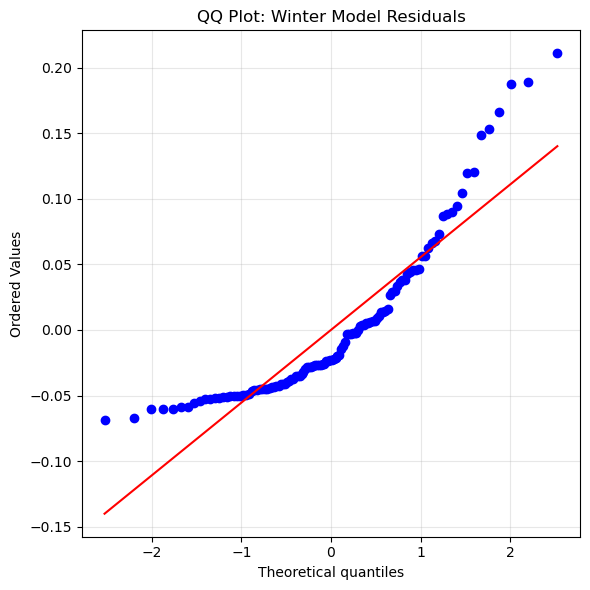

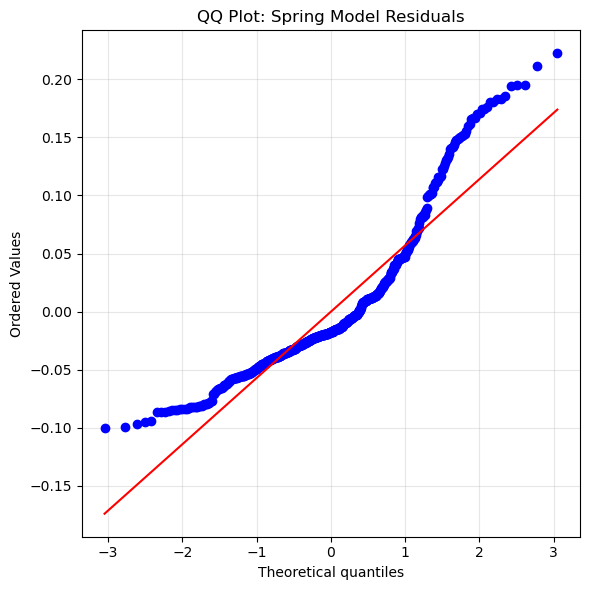

In [67]:

# QQ Plot - Winter Residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals_winter, dist="norm", plot=plt)
plt.title("QQ Plot: Winter Model Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# QQ Plot - Spring Residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals_spring, dist="norm", plot=plt)
plt.title("QQ Plot: Spring Model Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Visualization

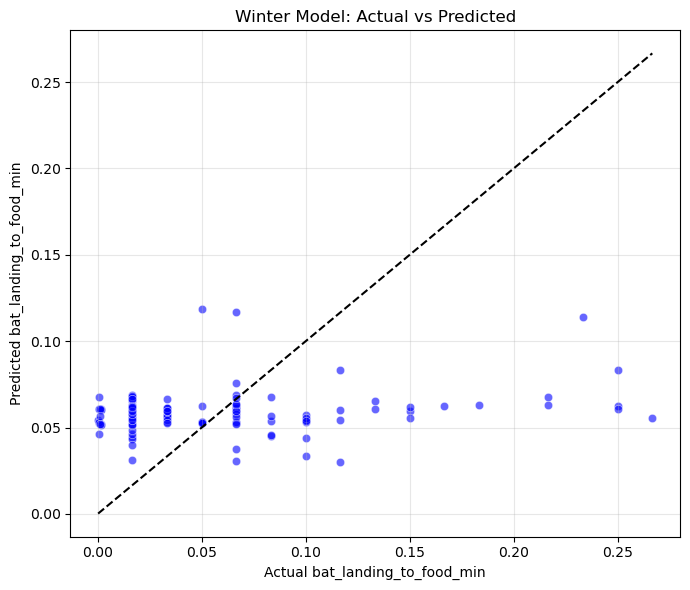

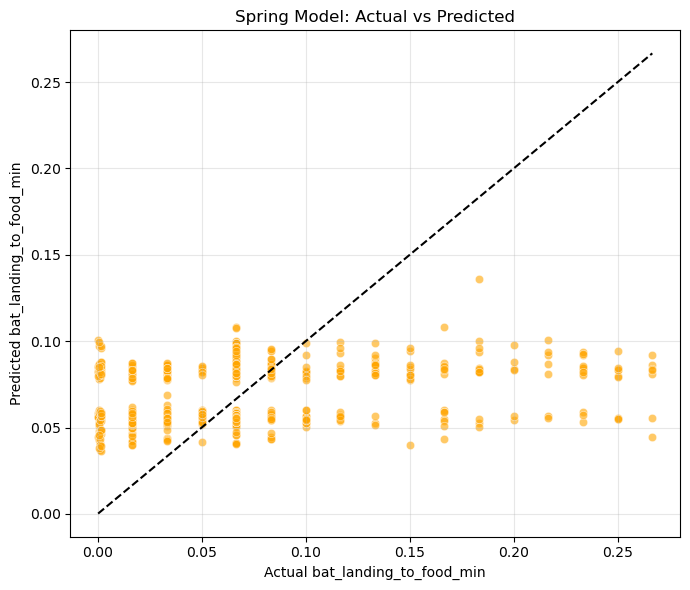

In [68]:
# Create DataFrames for plotting
df_winter_pred = pd.DataFrame({
    'Actual': yw_train.reset_index(drop=True),
    'Predicted': y_pred_winter,
    'Season': 'Winter'
})

df_spring_pred = pd.DataFrame({
    'Actual': ys_train.reset_index(drop=True),
    'Predicted': y_pred_spring,
    'Season': 'Spring'
})

# --- Winter Plot ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_winter_pred, x='Actual', y='Predicted', color='blue', alpha=0.6)
sns.lineplot(x=[df_winter_pred['Actual'].min(), df_winter_pred['Actual'].max()],
             y=[df_winter_pred['Actual'].min(), df_winter_pred['Actual'].max()],
             color='black', linestyle='--')
plt.title('Winter Model: Actual vs Predicted')
plt.xlabel('Actual bat_landing_to_food_min')
plt.ylabel('Predicted bat_landing_to_food_min')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Spring Plot ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_spring_pred, x='Actual', y='Predicted', color='orange', alpha=0.6)
sns.lineplot(x=[df_spring_pred['Actual'].min(), df_spring_pred['Actual'].max()],
             y=[df_spring_pred['Actual'].min(), df_spring_pred['Actual'].max()],
             color='black', linestyle='--')
plt.title('Spring Model: Actual vs Predicted')
plt.xlabel('Actual bat_landing_to_food_min')
plt.ylabel('Predicted bat_landing_to_food_min')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary

- **Data & Variables:**
    - We have two main seasonal datasets: `winter_df` and `spring_df`, each with features engineered for regression analysis.
    - The target variable for regression is `bat_landing_to_food_min`.
    - Feature lists for regression are defined as `w_features` (winter) and `s_features` (spring).
    - Data is split into train/test sets for both seasons (`yw_train`, `yw_test`, `ys_train`, `ys_test`).

- **Regression & Evaluation:**  
    - Linear regression models are trained and evaluated for both seasons.
    - Predictions for train and test sets are stored in variables like `y_pred_winter`, `y_pred_winter_test`, `y_pred_spring`, `y_pred_spring_test`.
    - Model performance is measured using MSE, RMSE, and R scores, both for train/test splits and cross-validation.
    - Cross-validation metrics are stored in lists such as `winter_mse_scores`, `winter_rmse_scores`, `winter_r2_scores`, `spring_mse_scores`, `spring_rmse_scores`, `spring_r2_scores`.

- **Feature Engineering & Multicollinearity:**  
    - Features include time intervals, risk/reward, food fraction, and seasonal indicators.
    - Multicollinearity is checked using correlation (`z` list) and VIF (`vif_data` DataFrame).
    - Highly correlated feature pairs are identified in `z`.

- **Standardization:**  
    - Features are standardized using `StandardScaler` objects (`winter_scaler`, `spring_scaler`).


# Regression Analysis Summary

## Model Performance Metrics

### Winter Model Performance (Poor Generalization)

The Winter model showed highly concerning performance on unseen data, failing to generalize effectively.

| Evaluation Set | R-squared ($R^2$) | MSE | RMSE |
| :---: | :---: | :---: | :---: |
| **Training** | 0.0432 | 0.0035 | 0.0591 |
| **Test** | **-0.0251** | 0.0029 | 0.0539 |
| **Cross-Validation (Avg.)** | -0.2137 | 0.0038 | 0.0686 |

<br>

> * **Interpretation:** The **Test Set $R^2$ of $-0.0251$** strongly suggests the linear relationship identified during training is either highly sensitive to the specific training data or that the underlying relationship is highly non-linear and cannot be approximated by a straight line, especially when faced with the variability of the test set.

### Spring Model Performance (Low Predictive Power)

The Spring model performs slightly better, but its predictive capability remains weak, with minimal variance explained.

| Evaluation Set | R-squared ($R^2$) | MSE | RMSE |
| :---: | :---: | :---: | :---: |
| **Training** | 0.0769 | 0.0035 | 0.0604 |
| **Test** | 0.0301 | 0.0032 | 0.0570 |
| **Cross-Validation (Avg.)** | 0.0421 | 0.0036 | 0.0600 |

<br>

> * **Interpretation:** The **Test Set $R^2$ of $0.0031$** means the model is unreliable and invalid for making predictions on new data. The low training **$R^2$ of $0.0769$** still suggests underfitting, where the model is too simple to capture the true, likely non-linear, relationship between the features and the target.

## Conclusion

The pervasive low $R^2$ values, particularly the negative scores on both test sets, confirm that the current structure of the `bat_landing_to_food_min` dataset, when paired with the chosen features, is **unsuitable for modeling with Linear Regression**. The complexity of the bat's behavior likely requires a more flexible approach. 